<a href="https://colab.research.google.com/github/TheDuyIT/MachineTranslation/blob/master/src/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import unicodedata
import time
import re
import numpy as np
import matplotlib.pyplot as plt
import jieba
import pandas as pd
from sklearn.utils import shuffle

## Setup input pipeline

In [ ]:
# dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Project/dataMe/cn_vn_8k.xlsx").drop(columns=["Unnamed: 0"])
# # dataset = dataset[:20000]
# content_vn = dataset["Viet"]
# content_cn = dataset["Trung"]
# dataset.shape

(87267, 2)

In [ ]:
# dataset.drop_duplicates()
# dataset.shape

(87267, 2)

In [ ]:
# print(len(max(vi_input, key=len)))
# print(len(min(vi_input, key=len)))

# print(len(max(cn_input, key=len)))
# print(len(min(cn_input, key=len)))

931
1
231
1


In [ ]:
dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/cn_vn.xlsx").drop(columns=["Unnamed: 0"])
dataset = dataset[:3000]
dataset = shuffle(dataset, random_state=42)
content_vn = dataset["Viet"]
content_cn = dataset["Trung"]
dataset.shape

(3000, 2)

In [ ]:
print(len(max(content_vn, key=len)))
print(len(min(content_vn, key=len)))

print(len(max(content_cn, key=len)))
print(len(min(content_cn, key=len)))

99
6
96
1


In [ ]:
def preproces_cn(s):
  return re.sub('\s+', ' ', ' '.join(s))
  seg_list = jieba.cut(s)
  return " ".join(seg_list)

for i in range(len(content_vn)):
  content_vn[i] = content_vn[i].lower()
for i in range(len(content_cn)):
  content_cn[i] = preproces_cn(content_cn[i])
# content_cn

In [ ]:
content_cn[3]

'“ 带 我 们 进 风 云 阁 。 ”'

In [ ]:
print(len(content_cn))
print(len(content_vn))

3000
3000


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(content_cn, content_vn, test_size=0.2, random_state=1)
X_val, y_val = [X_train[0]], [y_train[0]]

def create_dataset(x, y):
  a = tf.data.Dataset.from_tensor_slices(x)  # ==> [ 1, 2, 3 ]
  b = tf.data.Dataset.from_tensor_slices(y)
  ds = tf.data.Dataset.zip((a, b))
  ds = ds.shuffle(buffer_size = 1000)
  return ds

In [ ]:
full_dataset = create_dataset(content_cn, content_vn)
train_examples = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)
val_dataset = create_dataset(X_val, y_val)
# train_examples = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)
print(f'{len(full_dataset)} total pairs')
print(f'{len(train_examples)} training pairs')
print(f'{len(val_dataset)} validation pairs')
print(f'{len(test_dataset)} test pairs')

3000 total pairs
2400 training pairs
1 validation pairs
600 test pairs


In [ ]:
# tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_cn')
# tokenizer_cn = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_vn')
tokenizer_cn = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for en, _ in full_dataset), target_vocab_size=2**13)

tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (vn.numpy() for _, vn in full_dataset), target_vocab_size=2**13)

In [ ]:
tokenizer_cn.vocab_size

8183

In [ ]:
# for i in range(tokenizer_cn.vocab_size):
#   print(f'{i} ----> {tokenizer_cn.zzdecode([i])}')

In [ ]:
# tokenizer_cn.save_to_file('/content/drive/MyDrive/Colab Notebooks/tokenizer_cn')
# tokenizer_vn.save_to_file('/content/drive/MyDrive/Colab Notebooks/tokenizer_vn')

In [ ]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

In [ ]:
def encode(lang1, lang2):
  lang1 = [tokenizer_cn.vocab_size] + tokenizer_cn.encode(
      lang1.numpy()) + [tokenizer_cn.vocab_size+1]

  lang2 = [tokenizer_vn.vocab_size] + tokenizer_vn.encode(
      lang2.numpy()) + [tokenizer_vn.vocab_size+1]
  
  return lang1, lang2

In [ ]:
def tf_encode(en, vn):
  result_en, result_vn = tf.py_function(encode, [en, vn], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_vn.set_shape([None])

  return result_en, result_vn

In [ ]:
MAX_LENGTH = 250


In [ ]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [ ]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_dataset.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

test_dataset = test_dataset.map(tf_encode)
test_dataset = test_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


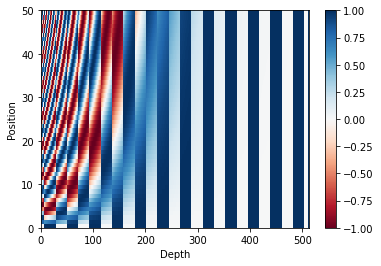

In [ ]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## Multi-head attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()
    
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
    
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

## Set hyperparameters

In [ ]:
num_layers = 6
d_model = 256 # model dim
dff = 512 # feed forward dim
num_heads = 8 # number of multi head attention d_model%num_heads == 0

input_vocab_size = tokenizer_cn.vocab_size + 2
target_vocab_size = tokenizer_vn.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def accuracy_function(real, pred):
  # print('000000000000000000000000000')
  # print(real)
  # print('111111111111111111111111111')
  # print(pred)
  # print('222222222222222222222222222')
  # print(tf.argmax(pred, axis=2))
  # print('333333333333333333333333333')

  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  # print(accuracies)
  # print('333333333333333333333333333')
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
# def accuracy_function(real, pred):
#   candidate = tf.argmax(pred, axis=2)
#   # print(real.)
#   print(real.numpy()[0][:-1])
#   print(tokenizer_vn.decode(real.numpy()[0][:-1]))
#   print(candidate.numpy()[0][:-1])
#   print(tokenizer_vn.decode(candidate.numpy()[0][:-1]))
#   # print(candidate)
#   # score = bleu_score(real, candidate)
#   score = 12
#   print(score)
#   return tf.constant(score)
# # bleu_function('real', 'pred')


In [ ]:
# dir(tokenizer_vn)

In [ ]:
# for i in content_vn[:12]:
#   if 'mãnh_' in i:
#     print(i)  

In [ ]:
# for i in range(100000):
#   print(tokenizer_vn._id_to_subword(i).encode('utf-8').decode('utf-8'))

In [ ]:
from collections import Counter
import math
def n_gram_generator(sentence,n= 2,n_gram= False):
    '''
    N-Gram generator with parameters sentence
    n is for number of n_grams
    The n_gram parameter removes repeating n_grams 
    '''
    sentence = sentence.lower() # converting to lower case
    sent_arr = np.array(sentence.split()) # split to string arrays
    length = len(sent_arr)

    word_list = []
    for i in range(length+1):
        if i < n:
            continue
        word_range = list(range(i-n,i))
        s_list = sent_arr[word_range]
        string = ' '.join(s_list) # converting list to strings
        word_list.append(string) # append to word_list
        if n_gram:
            word_list = list(set(word_list))
    return word_list
def bleu_score(original,machine_translated):
    '''
    Bleu score function given a orginal and a machine translated sentences
    '''
    mt_length = len(machine_translated.split())
    o_length = len(original.split())

    # Brevity Penalty 
    if mt_length>o_length:
        BP=1
    else:
        penality=1-(mt_length/o_length)
        BP=np.exp(penality)

    # Clipped precision
    clipped_precision_score = []
    for i in range(1, 5):
        original_n_gram = Counter(n_gram_generator(original,i))
        machine_n_gram = Counter(n_gram_generator(machine_translated,i))

        c = sum(machine_n_gram.values())
        for j in machine_n_gram:
            if j in original_n_gram:
                if machine_n_gram[j] > original_n_gram[j]:
                    machine_n_gram[j] = original_n_gram[j]
            else:
                machine_n_gram[j] = 0

        #print (sum(machine_n_gram.values()), c)
        clipped_precision_score.append(sum(machine_n_gram.values())/c)

    #print (clipped_precision_score)

    weights =[0.25]*4

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = BP * math.exp(math.fsum(s))
    return s

original = "It is a guide to action which ensures that the military alwasy obeys the command of the party"
machine_translated = "It is the guiding principle which guarantees the military forces alwasy being under the command of the party"

# print (bleu_score(original, machine_translated))
# print (sentence_bleu([original.split()], machine_translated.split()))

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(
    name='train_accuracy')

## Training and checkpointing

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/train1"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths o4/1AY0e-g5NwERYfvXHd5gYJ0PO1FU94gGYrmyMq14BU0Dlvo5oiSqu1suLElor variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  # print('inner train')
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    # print('---------------------------------')
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  # print('--------------------')
  # print(accuracy_function(tar_real, predictions))
  # print('--------------------')
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> en, tar -> vn
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 50 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

TypeError: ignored

In [ ]:
transformer.summary()

ValueError: ignored

In [ ]:
ckpt_save_path = ckpt_manager.save()

## Evaluate

In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_cn.vocab_size]
    end_token = [tokenizer_cn.vocab_size + 1]

    # inp sentence is eng, hence adding the start and end token
    inp_sentence = start_token + tokenizer_cn.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is vn, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_vn.vocab_size]
    output = tf.expand_dims(decoder_input, 0)


    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
    enc_output = transformer.encoder(encoder_input, False, enc_padding_mask)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
        dec_output, attention_weights = transformer.decoder(
            output, enc_output, False, combined_mask, dec_padding_mask)
        predictions = transformer.final_layer(dec_output)
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == tokenizer_vn.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(sentence, plot=''):
  sentence = preproces_cn(sentence)
  result, attention_weights = evaluate(sentence)
  predicted_sentence = tokenizer_vn.decode([i for i in result 
                                            if i < tokenizer_vn.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  return predicted_sentence

In [ ]:
data_test = train_pairs[:7000] + test_pairs[:3000] 
from nltk.translate.bleu_score import sentence_bleu

scores_bleu = 0
count_bleu = 0

for i in data_test[:100]:
      predict = translate(i[0])
      score = sentence_bleu(i[1], predict)
      scores_bleu += score
      count_bleu += 1
      print('Trung: ', i[0])
      print('actual: ', i[1])
      print('predicted: ', predict)
      print(score)
      print(count_bleu, end='-')

print('\n\nCount_bleu: ', count_bleu)
print('AVERAGE BLEU SCORE: ', scores_bleu/count_bleu)

Input: 下 滑
Predicted translation: từ chối
kr:  下 滑
actual:  từ chối
predicted:  từ chối
1.0
1-

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input: 主 导
Predicted translation: dẫn đầu
kr:  主 导
actual:  dẫn đầu
predicted:  dẫn đầu
1.0
2-Input: 團 結
Predicted translation: thống nhất
kr:  團 結
actual:  thống nhất
predicted:  thống nhất
0.9146912192286945
3-Input: 苏 木 无 语 ， 这 还 真 是 自 己 的 师 兄 呢 。
Predicted translation: tô mộc im lặng, người này đúng là sư huynh của hắn.
kr:  苏 木 无 语 ， 这 还 真 是 自 己 的 师 兄 呢 。
actual:  tô mộc im lặng, người này đúng là sư huynh của hắn.
predicted:  tô mộc im lặng, người này đúng là sư huynh của hắn.
0.8367437134595066
4-Input: 新 羅
Predicted translation: silla
kr:  新 羅
actual:  silla
predicted:  silla
0.9457416090031758
5-Input: 监 视
Predicted translation: giám sát
kr:  监 视
actual:  giám sát
predicted:  giám sát
0.9671682101338347
6-Input: 屹
Predicted translation: yi
kr:  屹
actual:  yi
predicted:  yi
1.0
7-Input: 这 个 节 目 她 演 得 好 不 好 ？
Predicted translation: bạn biểu mục này diễn văn cô ta thế nào?
kr:  这 个 节 目 她 演 得 好 不 好 ？
actual:  tiết mục này cô ta diễn có tốt không?
predicted:  bạn biểu mục này diễn 

In [ ]:
translate('你好！') #chào bạn

In [ ]:
translate('好')

In [ ]:
print(translate('听说越南的杂技很有意思，我还没看过呢。'))

In [ ]:
print(translate('你来过越南吗？你来越南以后去过什么地方？'))

In [ ]:
print(translate('我是越南人')) # tôi là người VN

In [ ]:

translate('越南') # VN

In [ ]:
translate('中国') # TQ

In [ ]:
translate('明天')  # ngày mai

In [ ]:
translate('我哥哥') # anh trai tôi

In [ ]:
print(translate('那是英文杂志。'))

In [ ]:
translate('那是英文杂志。')

In [ ]:
translate('英') # tieengs Anh

In [ ]:
translate('今天我的工作不太忙。') #Hôm nay công việc của tôi không quá bận.

In [ ]:
translate('今天') # ngày nay, hiện tại

In [ ]:
translate('工作') # công việc

In [ ]:
translate('拼命在脑海中寻你') #Khao khát tìm kiếm bạn trong tâm trí của tôi

In [ ]:
translate('默守着那个秘密') # âm thầm giữ kín bí mật

In [ ]:
translate('个秘密') # bí mật

In [ ]:
translate('请把飞机票和护照给我看一下儿。') #hãy đưa vé máy bay và hộ chiếu cho tôi xem một chút.

In [ ]:
translate('护照') # hộ chiếu

In [ ]:
print(translate('明天下了课我就去办公室找她。')) # Tôi sẽ đến văn phòng để tìm cô ấy sau giờ học vào ngày mai.

In [ ]:
print(translate('真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。')) #Thất bại thực sự không bao giờ là kết quả của việc không chỉ đạt được yêu cầu mà còn là sự phung phí khi bạn có nó, và bỏ cuộc nhẹ nhàng trước khi cố gắng hết sức.

In [ ]:
print(translate('真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。'))
# Thất bại thực sự không bao giờ là kết quả của việc không chỉ đạt được yêu cầu mà còn là sự phung phí khi bạn có nó, và bỏ cuộc nhẹ nhàng trước khi cố gắng hết sức.

In [ ]:
print(translate('你的名字写下来不过几厘米长，却贯穿了我这么长时光。其实你不知道，你一直是我的梦想。'))
# Tên của bạn chỉ dài vài cm khi viết ra, nhưng nó đã xuyên suốt thời gian của tôi. Thực ra bạn không biết, bạn đã luôn là giấc mơ của tôi.